In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import numpy as np

def tommre(R, Vcirc, sigma_R, surf_den, G = 4.299e-6):
    
    a0 = (Vcirc/R)**2
    dV = np.diff(Vcirc)
    dR = np.diff(R)
    
    Rmed  = R[:-1] + dR
    deriv = np.interp(R,Rmed,dV/dR)
    
#     plt.plot(Rmed,dV/dR, '-')
#     plt.plot(R,deriv,'-')
    
    k = 2.*a0*(1. + (R/Vcirc) *deriv )
    
#     print k
    Q = sigma_R*np.sqrt(k)/(3.36*G*surf_den)
    
    return Q 

In [2]:
import gadget_reader as gd
path = '/home/omarioni/Model_D1/'
sim = gd.Open(path+'snap_010', gadget_type=1, verbose=False)

pdrk = sim.Read('POS ', 1)
pstr = sim.Read('POS ', 2)

mdrk = sim.Read('MASS', 1)
mstr = sim.Read('MASS', 2)

vel  = sim.Read('VEL ', 2)

Text(0.5,0,'x[kpc]')

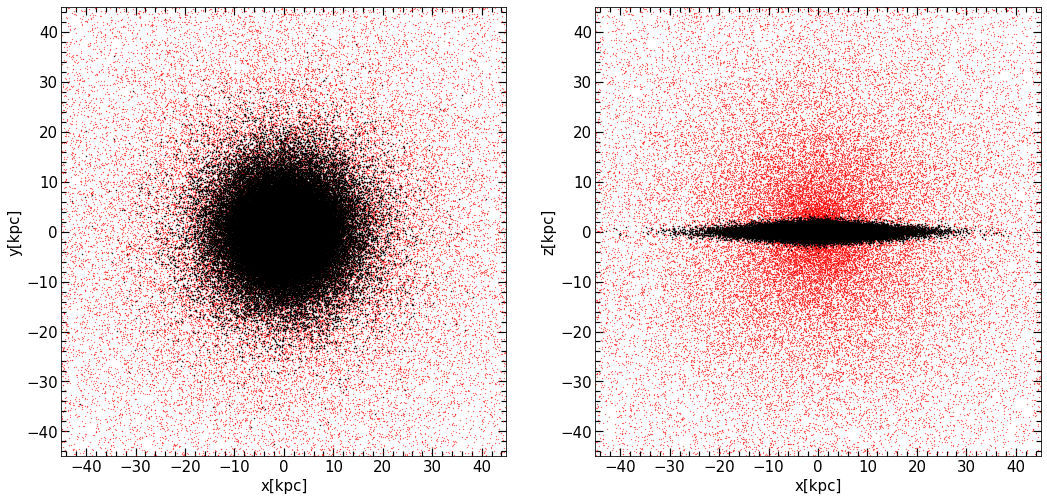

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0.2, hspace= 0)

ax[0].plot(pdrk[0,:],pdrk[1,:],'r.',markersize=0.5)
ax[0].plot(pstr[0,:],pstr[1,:],'k.',markersize=1)
ax[0].set_xlim(-45,45)
ax[0].set_ylim(-45,45)
ax[0].minorticks_on()
ax[0].tick_params( labelsize=15)
ax[0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[0].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[0].set_ylabel('y[kpc]',fontsize=15)
ax[0].set_xlabel('x[kpc]',fontsize=15)

ax[1].plot(pdrk[0,:],pdrk[2,:],'r.',markersize=0.5)
ax[1].plot(pstr[0,:],pstr[2,:],'k.',markersize=1)
ax[1].set_xlim(-45,45)
ax[1].set_ylim(-45,45)
ax[1].minorticks_on()
ax[1].tick_params( labelsize=15)
ax[1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax[1].tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax[1].set_ylabel('z[kpc]',fontsize=15)
ax[1].set_xlabel('x[kpc]',fontsize=15)

In [3]:
sim.Property

['HEAD', 'POS ', 'VEL ', 'ID  ', 'MASS', 'U   ']

In [5]:
import numpy as np
G = 4.299e-6

rstr = np.sqrt(pstr[0,:]**2 + pstr[1,:]**2 + pstr[2,:]**2)
rdrk = np.sqrt(pdrk[0,:]**2 + pdrk[1,:]**2 + pdrk[2,:]**2)

mask_str, = np.where(rstr<200)
mask_drk, = np.where(rdrk<200)

str_sort = np.argsort(rstr[mask_str])
drk_sort = np.argsort(rdrk[mask_drk])

rstr_ = rstr[mask_str]
rdrk_ = rdrk[mask_drk]

mstr_ = mstr[mask_str]
mdrk_ = mdrk[mask_drk]

Mstr = np.cumsum(mstr_[str_sort])*1e10
Mdrk = np.cumsum(mdrk_[drk_sort])*1e10

rtot = np.concatenate([rstr_,rdrk_])
tot_sort = np.argsort(rtot)

mtot = np.concatenate([mstr_,mdrk_])

Mtot = np.cumsum(mtot[tot_sort])*1e10

Vstr = np.sqrt(G*Mstr/rstr_[str_sort])
Vdrk = np.sqrt(G*Mdrk/rdrk_[drk_sort])
Vtot = np.sqrt(G*Mtot/rtot[tot_sort])

Aca solo estoy testeando que la veloc bineada me de bien

In [6]:
import circular_velocity as vcirc
nbin = 50
vc, r_vc = vcirc.Vc_bin(rtot, mtot*1e10, nbin)

(0, 30)

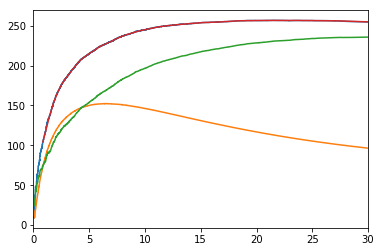

In [7]:
import matplotlib.pyplot as plt
plt.plot(rtot[tot_sort],Vtot)
plt.plot(rstr_[str_sort],Vstr)
plt.plot(rdrk_[drk_sort],Vdrk)
plt.plot(r_vc, vc)
plt.xlim(0,30)

In [9]:
import rotation_mio as rot
import time_conversion as tiempo
import bines2
import density as den
import circular_velocity as vcirc
import numpy as np

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/Toomre/test/'

G = 4.299e-6

xstr = pstr[0,:]
ystr = pstr[1,:]
zstr = pstr[2,:]
rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)

xdrk = pdrk[0,:]
ydrk = pdrk[1,:]
zdrk = pdrk[2,:]
rdrk = np.sqrt(xdrk**2 + ydrk**2 + zdrk**2)
    
vx = vel[0,:] 
vy = vel[1,:] 
vz = vel[2,:] 


corte_str, = np.where(rstr < 200)
corte_drk, = np.where(rdrk < 200)

R = np.sqrt(xstr[corte_str]**2 + ystr[corte_str]**2)

nbin = 50 #20
rbin, nodos = bines2.rbin1(R, nbin)

Vr = (xstr[corte_str]*vx[corte_str] + ystr[corte_str]*vy[corte_str])/R
Vz = vz[corte_str]
Vt = (xstr[corte_str]*vy[corte_str] - ystr[corte_str]*vx[corte_str])/R

sigma_z = np.zeros(nbin)
sigma_R = np.zeros(nbin)
sigma_t = np.zeros(nbin)


for j in range(nbin):
    mask, = np.where((nodos[j] < R) & (nodos[j+1] > R))
    n = len(mask)
    Vz_mean = np.mean(Vz[mask])
    Vr_mean = np.mean(Vr[mask])
    Vt_mean = np.mean(Vt[mask])

    sigma_z[j] = np.sqrt(sum((Vz[mask] - Vz_mean)**2)/n)
    sigma_R[j] = np.sqrt(sum((Vr[mask] - Vr_mean)**2)/n)
    sigma_t[j] = np.sqrt(sum((Vt[mask] - Vt_mean)**2)/n)


surf_den, rden = den.surf_density(R, mstr[corte_str]*1e10, nbin)


rtot= np.concatenate([rstr[corte_str], rdrk[corte_drk]])
mtot= np.concatenate([mstr[corte_str], mdrk[corte_drk]])

vc, r_vc = vcirc.Vc_bin(rtot, mtot*1e10, nbin)

Q = tommre(rbin, vc, sigma_R, surf_den)

data = np.ndarray([nbin,8])
data[:,0] = rbin
data[:,1] = sigma_z
data[:,2] = sigma_R
data[:,3] = sigma_t
data[:,4] = surf_den
data[:,5] = vc
data[:,6] = r_vc
data[:,7] = Q

np.savetxt(path2 + 'Q_test.dat',data, fmt='%12.6f')
# np.savetxt('../_data/Q_test.dat',data, fmt='%12.6f')

In [11]:
path = '/home/omarioni/'
data = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/Toomre/test/Q_test.dat')
rbin   = data[:,0]
sigmaz = data[:,1]
sigmaR = data[:,2]
surden = data[:,4]
Vcirc  = data[:,5]
r_vc   = data[:,6]
Q      = data[:,7]

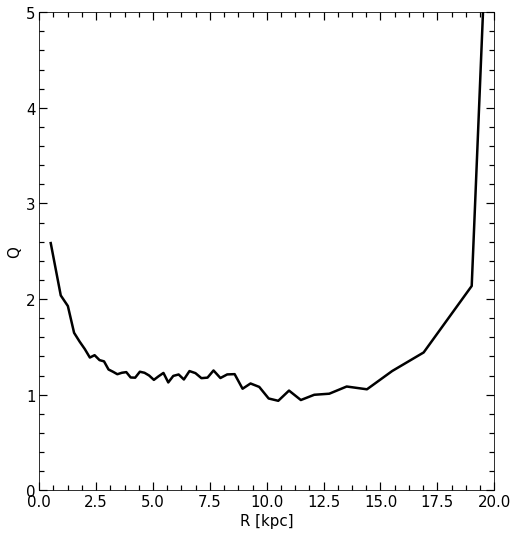

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, Q,'-', lw=2.5, color='k')

ax.set_ylim(0,5)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('Q',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

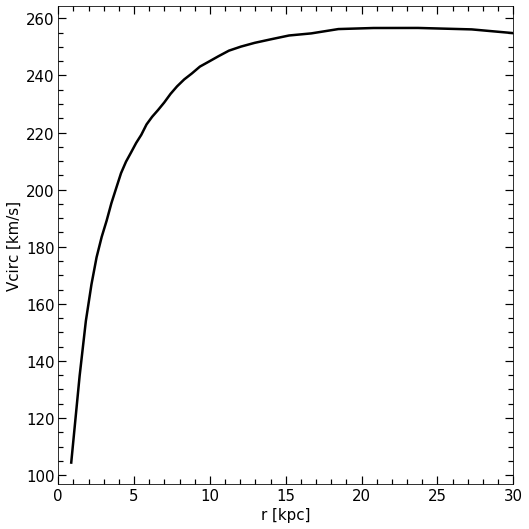

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(r_vc, Vcirc,'-', lw=2.5, color='k')

#  ax.set_ylim(0,5)
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('Vcirc [km/s]',fontsize=15)
ax.set_xlabel('r [kpc]',fontsize=15)
ax.set_xlim(0,30)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

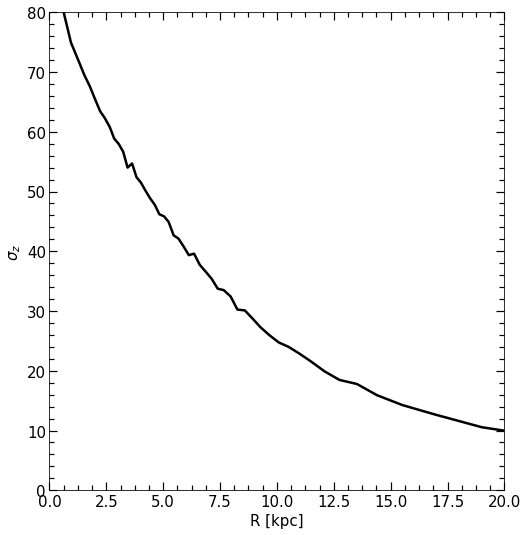

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigmaz,'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$\sigma_z$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
ax.set_ylim(0,80)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

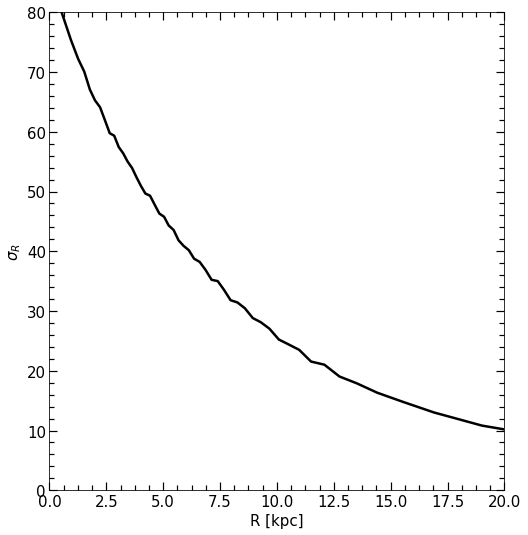

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigmaR,'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$\sigma_R$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
ax.set_ylim(0,80)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

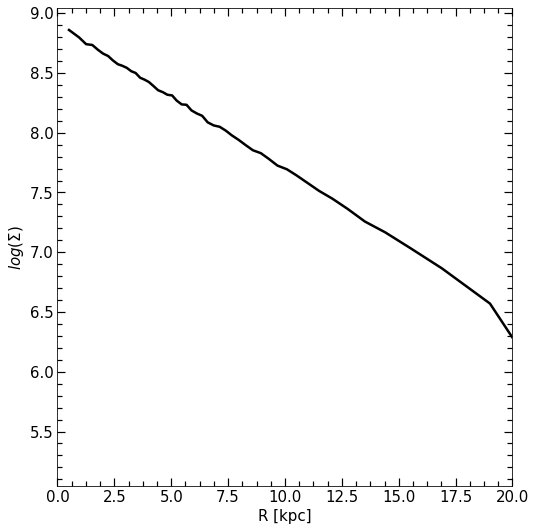

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, np.log10(surden),'-', lw=2.5, color='k')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylabel('$log(\Sigma)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_xlim(0,20)
# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

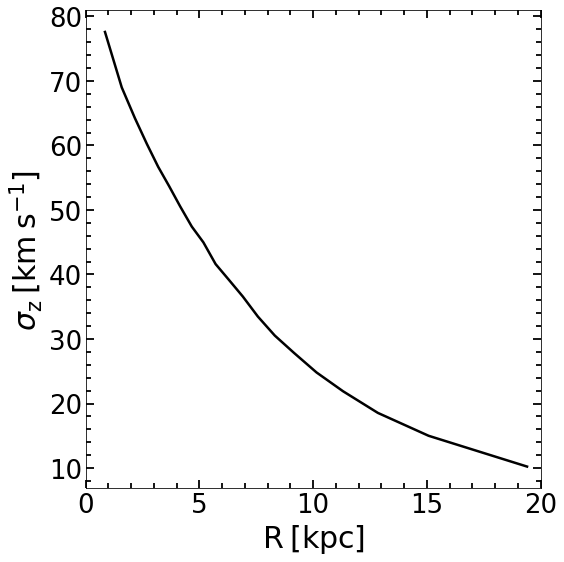

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigmaz,'k', lw=2.5)

ax.set_ylabel(r'$\sigma_{\mathrm{z}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)

# ax.set_ylim(0,0.7)
ax.set_xlim(0,20)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='true',top='true')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='true',top='true')
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

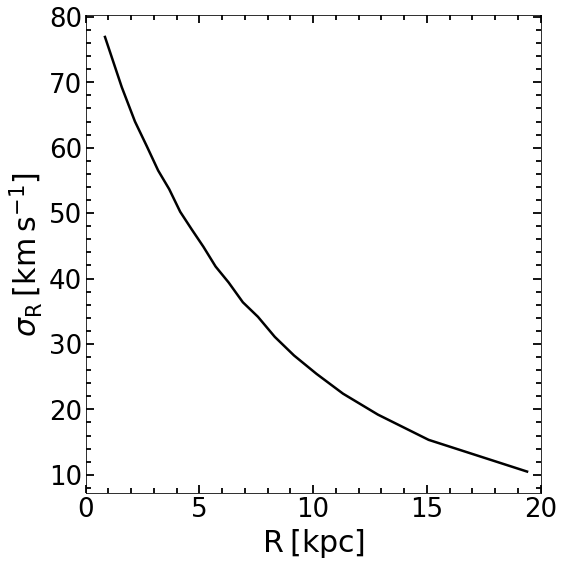

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, sigmaR,'-', lw=2.5, color='k')

# ax.set_yscale('log')
ax.set_ylabel(r'$\sigma_{\mathrm{R}} \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,20)
# ax.set_ylim(0,0.7)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='true',top='true')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='true',top='true')
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

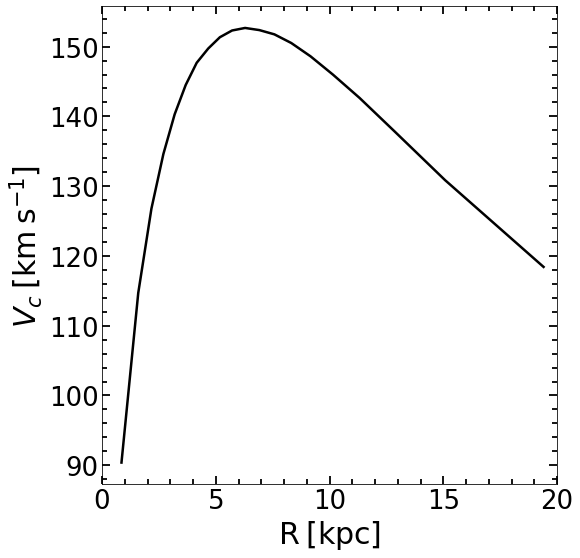

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, Vcirc,'-', lw=2.5, color='k')


ax.set_ylabel(r'$V_c \: \mathrm{[km\:s^{-1}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
ax.set_xlim(0,20)
# ax.set_ylim(0,0.7)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='true',top='true')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='true',top='true')
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

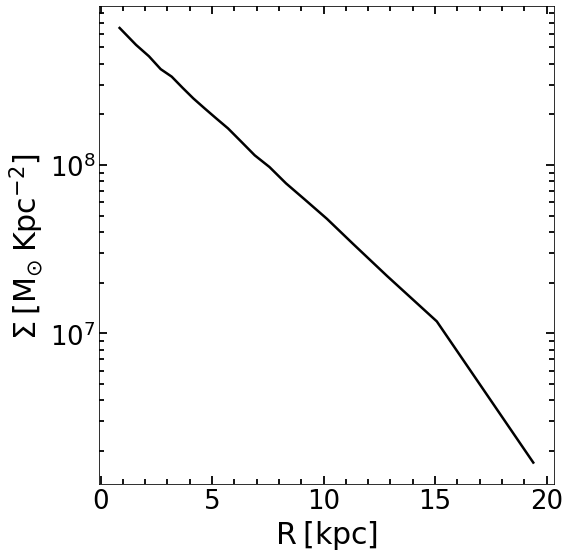

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True
#                        gridspec_kw = {'height_ratios':[3,1,3,1]}
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(rbin, surden,'-', lw=2.5, color='k')

ax.set_yscale('log')
ax.set_ylabel(r'$\Sigma \: \mathrm{[M_{\odot}\:Kpc^{-2}]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{R\:[kpc]}$',fontsize=30)
# ax.set_xticks([0,1,2,3,4,5])
# ax.set_xlim(0,5)
# ax.set_ylim(0,0.7)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='true',top='true')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='true',top='true')
ax.legend(fontsize=21,frameon=False, loc=1)

# fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/sigma_R.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def tommre(R, Vcirc, sigma_R, surf_den, G = 4.299e-6):
    
    a0 = (Vcirc/R)**2
    dV = np.diff(Vcirc)
    dR = np.diff(R)
    
    Rmed  = R[:-1] + dR
    deriv = np.interp(R,Rmed,dV/dR)
    
#     plt.plot(Rmed,dV/dR, '-')
#     plt.plot(R,deriv,'-')
    
    k = 2.*a0*(1. + (R/Vcirc) *deriv )
    
#     print k
    Q = sigma_R*np.sqrt(k)/(3.36*G*surf_den)
    
    return Q, np.sqrt(k)

In [30]:
Q = tommre(rbin, Vcirc,sigmaR,surden)